## Library Setup

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Transfer Learning - VGG16

In [2]:
# loading pre-trained model
vgg_model = VGG16()

In [3]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
# as we don't want to do predictions
# we won't need last decision layer ( i.e. predictions (Dense) )

feature_extractor = Model(inputs = vgg_model.input, outputs = vgg_model.get_layer("fc2").output)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Getting Images path

In [5]:
# parameters setup

imgs_path = 'Dresses'

imgs_width = 224
imgs_height = 224

# number of most similar images to retrieve
nb_closest_images = 10 

In [13]:
# getting list of all images absolute path into one list

img_files = []
img_labels = []

count = 0

# checking how many images are there

for label in sorted(os.listdir(imgs_path)):
    
    if count == 500:
        break
        
    else:
        # avoid unnecesaary folders
        if label == '.DS_Store':
            continue

        else:
            img_labels.append(label)
            
            for img in sorted(os.listdir(os.path.join(imgs_path, label))):

                # we will be only considering .jpg files
                # we are doing this to avoid any other media file to interfere with our model
                if 'jpg' in img:

                    # getting each image's absolute path
                    absolute_path_of_each_img = os.path.join(imgs_path, label, img)

                    # append into our list individually 
                    img_files.append(absolute_path_of_each_img)

    count += 1
     
print('Total Labels =', len(img_labels))
print("Total Images =", len(img_files))

Total Labels = 500
Total Images = 2780


## Checking any one Image

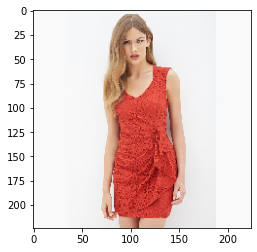

Dresses/id_00000472/02_1_front.jpg


In [58]:
og_img = load_img(img_files[404], target_size=(imgs_width, imgs_height))

plt.imshow(og_img)
plt.show()

print(img_files[404])

In [50]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)

np_img = img_to_array(og_img)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.

img_batch = np.expand_dims(np_img, axis=0)

print(img_batch.shape)

(1, 224, 224, 3)


In [17]:
# prepare the image for the VGG model

processed_image = preprocess_input(img_batch.copy())

In [18]:
# get the features

img_features = feature_extractor.predict(processed_image)

In [19]:
img_features.size, img_features

(4096, array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         1.1884747]], dtype=float32))

## Feed all Images to get their final features

In [20]:
Images = []

for img in img_files:
    
    og = load_img(img, target_size=(224, 224))
    np_og = img_to_array(og)
    og_batch = np.expand_dims(np_og, axis=0)
    
    Images.append(og_batch)

In [21]:
images = np.vstack(Images)

In [22]:
images.shape

(2780, 224, 224, 3)

In [23]:
processed_imgs = preprocess_input(images.copy())

In [24]:
# extract features

imgs_features = feature_extractor.predict(processed_imgs)

In [25]:
imgs_features.shape

(2780, 4096)

## Cosine Similarity

In [26]:
cosSimilarities = cosine_similarity(imgs_features)

In [27]:
# storing this in Dataframe

cos_similarity = pd.DataFrame(cosSimilarities, columns=img_files, index=img_files)

In [28]:
cos_similarity.shape

(2780, 2780)

In [29]:
cos_similarity.head()

,Dresses/id_00000002/02_1_front.jpg,Dresses/id_00000002/02_2_side.jpg,Dresses/id_00000002/02_4_full.jpg,Dresses/id_00000002/02_7_additional.jpg,Dresses/id_00000008/02_3_back.jpg,Dresses/id_00000008/02_7_additional.jpg,Dresses/id_00000009/02_1_front.jpg,Dresses/id_00000009/02_2_side.jpg,Dresses/id_00000009/02_3_back.jpg,Dresses/id_00000009/02_4_full.jpg,...,Dresses/id_00003422/04_7_additional.jpg,Dresses/id_00003426/03_1_front.jpg,Dresses/id_00003426/03_2_side.jpg,Dresses/id_00003426/03_3_back.jpg,Dresses/id_00003426/03_7_additional.jpg,Dresses/id_00003455/02_1_front.jpg,Dresses/id_00003455/02_2_side.jpg,Dresses/id_00003455/02_3_back.jpg,Dresses/id_00003455/02_4_full.jpg,Dresses/id_00003455/02_7_additional.jpg
Dresses/id_00000002/02_1_front.jpg,1.000000,0.884545,0.784795,0.792642,0.730325,0.663852,0.770692,0.745761,0.716297,0.655289,...,0.825574,0.812393,0.746829,0.667354,0.560419,0.797078,0.818554,0.783260,0.716053,0.726470
Dresses/id_00000002/02_2_side.jpg,0.884545,1.000000,0.765852,0.857212,0.655413,0.652557,0.716131,0.719154,0.721009,0.615679,...,0.730932,0.755811,0.648829,0.602575,0.492562,0.758603,0.825301,0.772275,0.671692,0.673997
Dresses/id_00000002/02_4_full.jpg,0.784795,0.765852,1.000000,0.717435,0.675094,0.797079,0.647694,0.690465,0.639529,0.741856,...,0.685238,0.740872,0.667150,0.655488,0.690553,0.703402,0.757192,0.731408,0.773814,0.835687
Dresses/id_00000002/02_7_additional.jpg,0.792642,0.857212,0.717435,1.000000,0.662356,0.611118,0.734922,0.743906,0.755318,0.614795,...,0.682017,0.702819,0.615879,0.586494,0.492125,0.698230,0.773940,0.726607,0.626739,0.646539
Dresses/id_00000008/02_3_back.jpg,0.730325,0.655413,0.675094,0.662356,1.000000,0.736888,0.705007,0.696727,0.629104,0.664850,...,0.745059,0.839975,0.858310,0.825355,0.758881,0.751628,0.717883,0.802326,0.766214,0.737979


In [31]:
cos_similarity.to_csv('all_similarites_DeepFashion_data_women.csv')

In [32]:
def retrieve_similarity(given_img):
    
    print("Original Product")
    
    og = load_img(given_img, target_size=(224, 224))
    
    plt.imshow(og)
    plt.show()
    
    print("Similar Products")
    
    closest_imgs = cos_similarity[given_img].sort_values(ascending=False)[1: nb_closest_images+1].index
    closest_imgs_scores = cos_similarity[given_img].sort_values(ascending=False)[1: nb_closest_images+1]
    
    for i in range(len(closest_imgs)):
        
        if os.path.split(given_img)[0] == os.path.split(closest_imgs[i])[0]:
            continue
        
        else:
            og = load_img(closest_imgs[i], target_size=(224, 224))
            plt.imshow(og)
            plt.show()
            print("similarity score : ",closest_imgs_scores[i])

Original Product


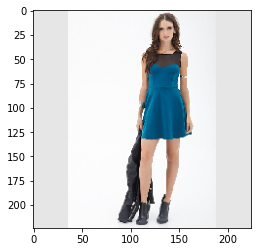

Similar Products


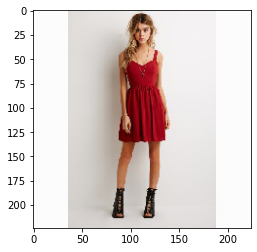

similarity score :  0.88738924


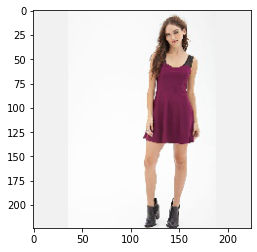

similarity score :  0.8853624


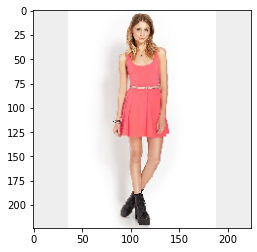

similarity score :  0.8811033


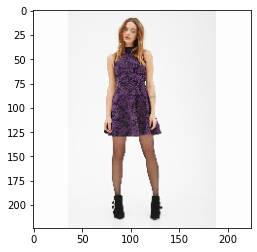

similarity score :  0.8798714


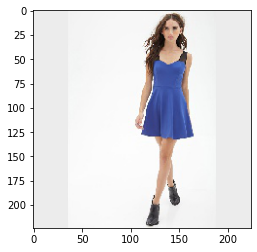

similarity score :  0.8776176


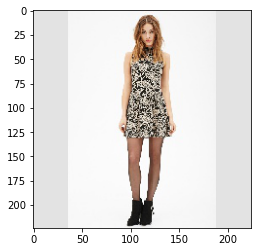

similarity score :  0.876872


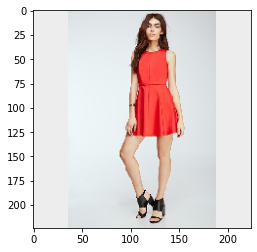

similarity score :  0.8765623


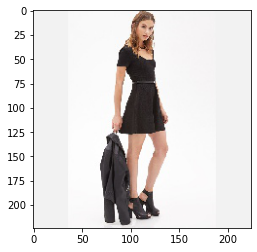

similarity score :  0.8764342


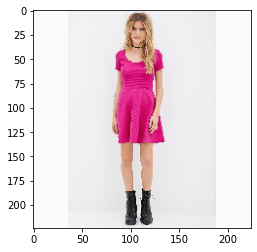

similarity score :  0.87356997


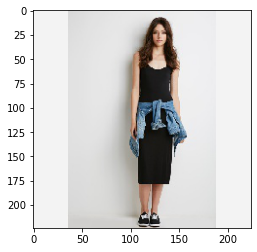

similarity score :  0.869204


In [60]:
ip = 'Dresses/id_00000348/07_4_full.jpg'

retrieve_similarity(ip)